# Chapter overview
This chapter focuses on working with image pixels
* Changing colors
* Change to grayscale
* Using the `ImageFiltering` package
* Improve color intensity
* Linear and Non-Linear intensity (e.g. Sharpening, blurring, smoothing)

# Libraries

In [1]:
using Images, ImageView, Colors

Gtk-Message: 12:28:40.634: Failed to load module "canberra-gtk-module"
Gtk-Message: 12:28:40.635: Failed to load module "canberra-gtk-module"


# Images as arrays
Julia Images are two-dimensional arrays. Every pixel can be scalar (grayscale) or a 1D array (with multiple color channels).

*PNG images with transparent background are called RGBA*

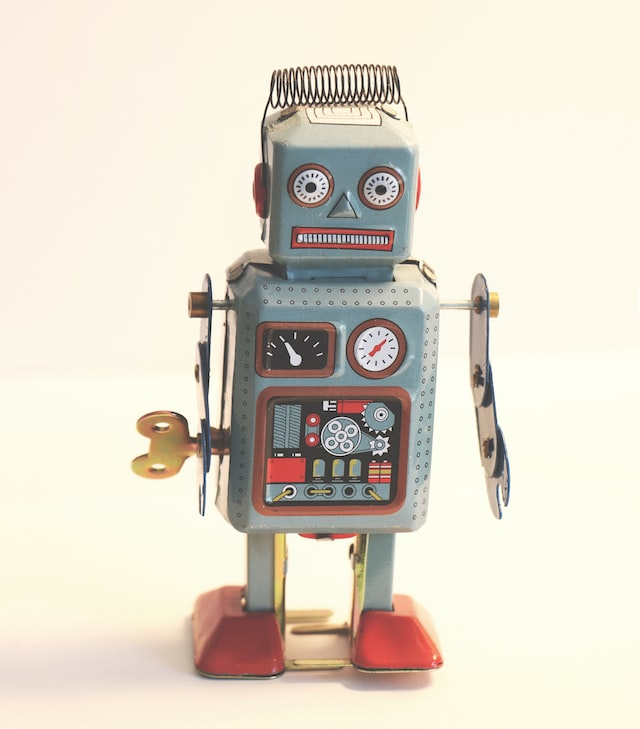

In [2]:
image_path = "Images/robot.jpg"
img = load(image_path)

## Composition of a single RGB Pixel

In [3]:
img[1:1, 1:1, :]

# The selected pixel is composed of an RGB object
# with the decimal values corresponding to each RGB channel.
# 0: Black. 1: White (saturated)
# Decimals correspond to 8-bit integers scaled by 1/255 (helpful for Neural Network pre-processing)

1×1×1 Array{RGB{N0f8},3} with eltype RGB{N0f8}:
[:, :, 1] =
 RGB{N0f8}(0.984,0.929,0.886)

## Decomposing an image into multiple channels using `channelview`

In [4]:
function recoloring_threshold(image_path, from_px, to_px)
    copy_img = load(image_path)
    im_channels = channelview(copy_img);

    im_channels[im_channels .> from_px] *= to_px

    return copy_img
end

recoloring_threshold (generic function with 1 method)

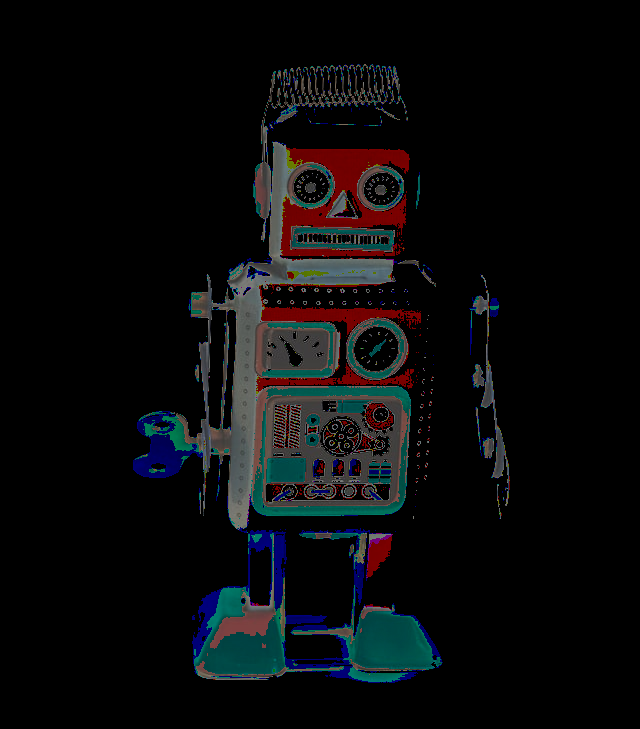

In [5]:
recoloring_threshold(image_path, 0.5, 0.0)

## Converting number arrays into colors with `colorview`

After defining a random array, we can rearrange the order of the parameters with `permutedims(img, [new_order])`

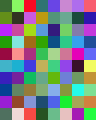

In [6]:
random_img_array = rand(3, 10, 8) #Channel, height, width
random_img = colorview(RGB, random_img_array)

## Changing Color Saturation for the right half of an image.

In [7]:
# Original image size
size(img)

(729, 640)

In [8]:
function change_saturation(image_path, rgb_arr)
    """
    Input:
    * image_path: Location and name of image to load
    * rgb_arr: saturation for each RGB component
    """
    img = load(image_path);
    
    # We define dimensions of right half of image.
    x_coords = Int(size(img, 2)/2):size(img, 2);    
    
    img_channel_view = channelview(img);
    img_channel_view = permuteddimsview(img_channel_view, (2, 3, 1));
    
    img_channel_view[:, x_coords, 1] = min.(img_channel_view[:, x_coords, 1] .* rgb_arr[1], 1);
    img_channel_view[:, x_coords, 2] = min.(img_channel_view[:, x_coords, 2] .* rgb_arr[2], 1);
    img_channel_view[:, x_coords, 3] = min.(img_channel_view[:, x_coords, 3] .* rgb_arr[3], 1);
    
    return img
end

change_saturation (generic function with 1 method)

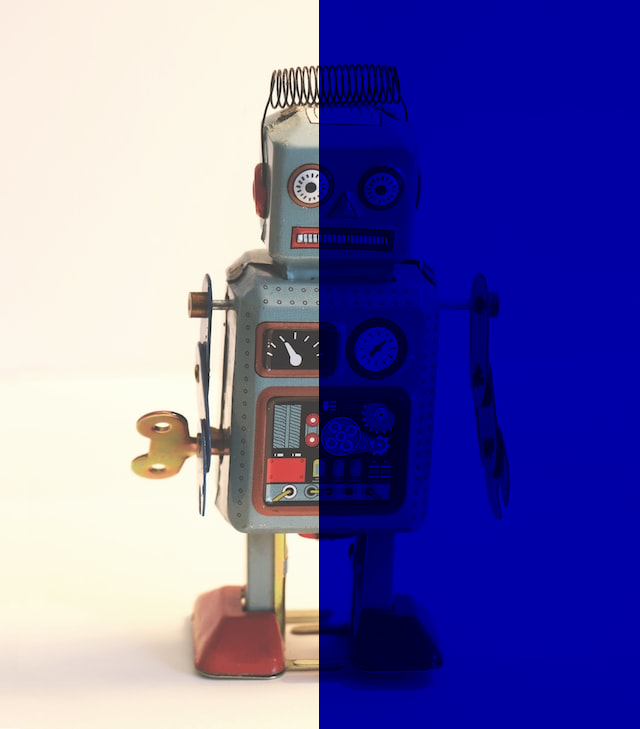

In [9]:
change_saturation(image_path, [0, 0, 0.7])

## Change image to grayscale
Grayscale images are used for tasks like morphology or feature detection. This single channel image simplifies processing for faster analysis.

In [10]:
function make_grayscale(image_path)
    return Gray.(load(image_path));
end

make_grayscale (generic function with 1 method)

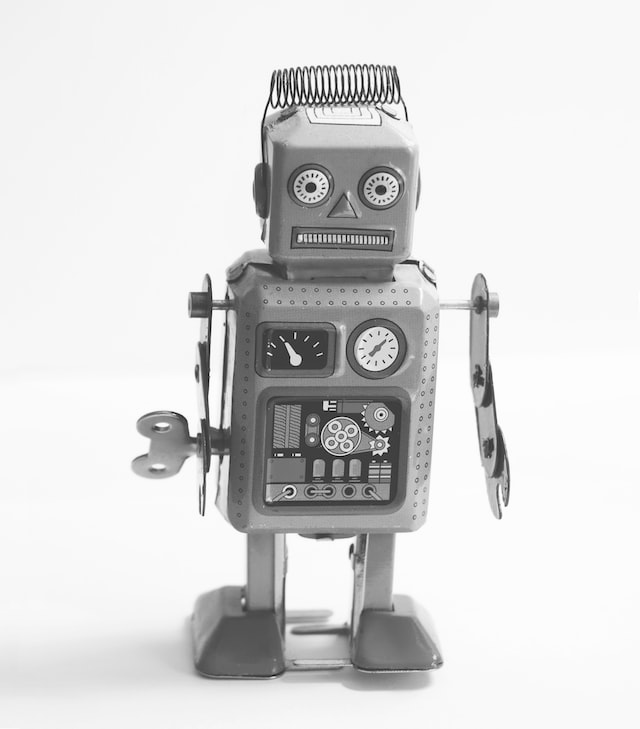

In [11]:
make_grayscale(image_path)

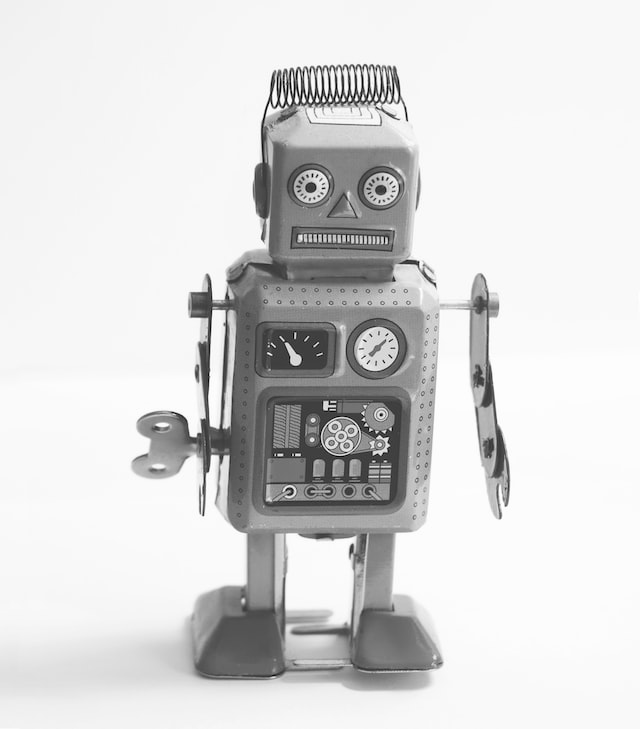

In [12]:
# A single channel grayscale image can be reprocessed as a 3 channel RGB image
# Yes, the color is already gone and it's an irreversible process.
RGB.(make_grayscale(image_path))

## Exercise: Custom filter
We create a color-splash filter by using a spot or area representing the colors to be retained. 

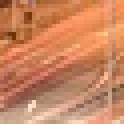

In [16]:
image_path = "Hands-On-Computer-Vision-with-Julia/sample-images/busan-night-scene.jpg"

# Load image
original_img = load(image_path);

# We create a 3-channel grayscale image
gray_img = RGB.(Gray.(load(image_path)));

# 1. Channel split
o_img_channel = channelview(original_img);
g_img_channel = channelview(gray_img);

# Move Channels dimension last. 
o_img_arr = permuteddimsview(o_img_channel, (2, 3, 1));
g_img_arr = permuteddimsview(g_img_channel, (2, 3, 1));

# We initialize a mask to keep track of color pixels to retain.
img_mask = fill(true, size(original_img));

# Area with color pixels to retain
img_spot_height = 430:460
img_spot_width = 430:460

# preview color area (optional)
#imshow(img[img_spot_height, img_spot_width])
original_img[img_spot_height, img_spot_width]

In [17]:
# We operate over every channel
for channel_id = 1:3
    # From each channel in the original RGB image, crop area with colors to retain 
    current_channel = view(o_img_arr, :, :, channel_id)
    current_channel_area = current_channel[img_spot_height, img_spot_width, :]

    # identify min and max values in a cropped area
    channel_min = minimum(current_channel_area)
    channel_max = maximum(current_channel_area)

    # merge existing mask with a channel specific mask
    channel_mask = channel_min .< current_channel .< channel_max
    img_mask = img_mask .& channel_mask
end    

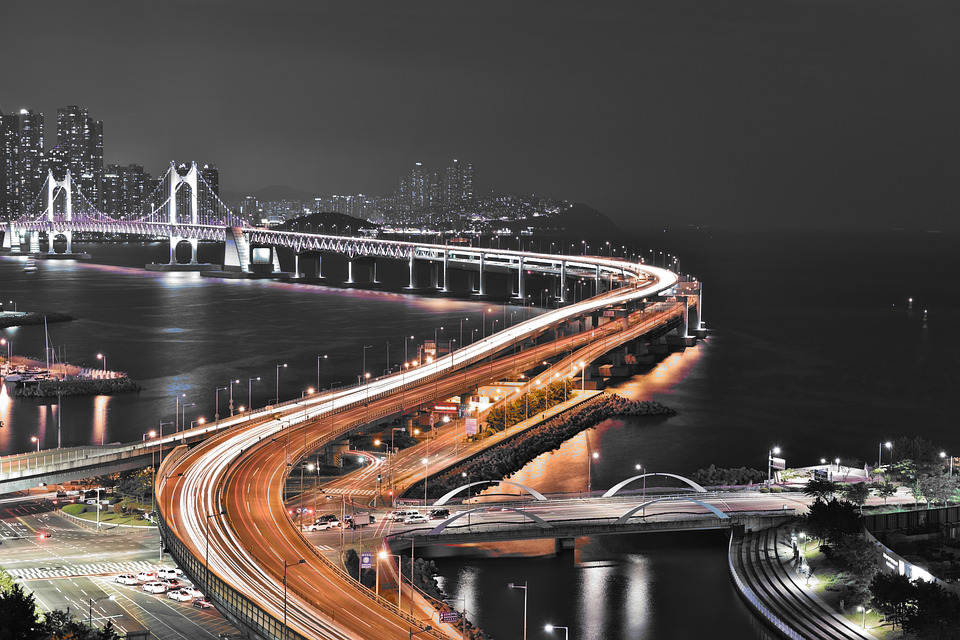

In [18]:
# Apply the mask 
img_masked = o_img_arr .* img_mask .+ g_img_arr .* .~(img_mask);
final_image = colorview(RGB, permutedims(img_masked, (3, 1, 2)))